Starting Standard WGAN Training on MNIST...
Epoch [0/20] Batch 400 Loss D: -0.4038, Loss G: 0.2124
Epoch [0/20] Batch 800 Loss D: -0.3985, Loss G: 0.2117


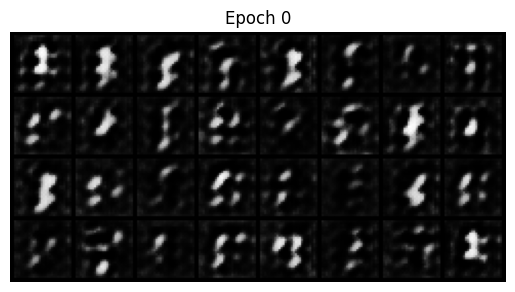

Epoch [1/20] Batch 400 Loss D: -0.3193, Loss G: 0.1562
Epoch [1/20] Batch 800 Loss D: -0.2091, Loss G: 0.1281


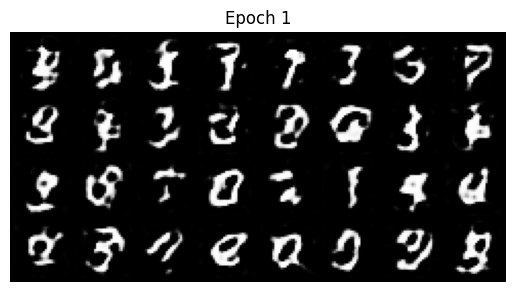

Epoch [2/20] Batch 400 Loss D: -0.1465, Loss G: 0.1205
Epoch [2/20] Batch 800 Loss D: -0.1443, Loss G: 0.1286


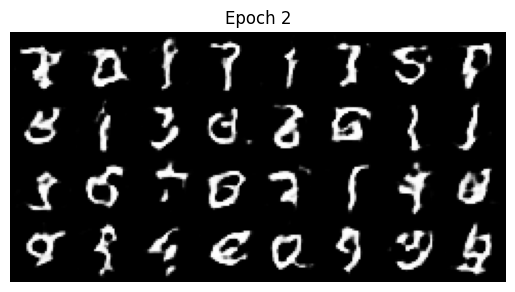

Epoch [3/20] Batch 400 Loss D: -0.1256, Loss G: 0.1201
Epoch [3/20] Batch 800 Loss D: -0.1355, Loss G: 0.0406


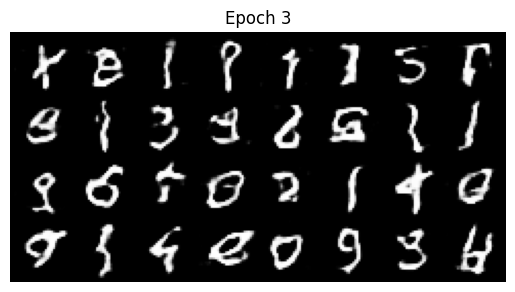

Epoch [4/20] Batch 400 Loss D: -0.1168, Loss G: 0.1178
Epoch [4/20] Batch 800 Loss D: -0.1006, Loss G: 0.0462


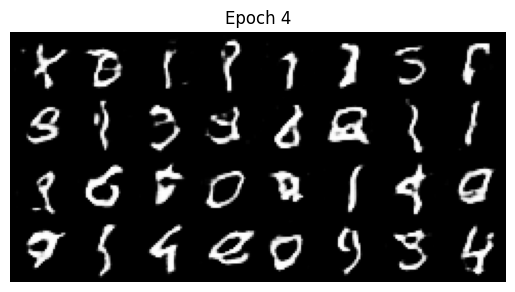

Epoch [5/20] Batch 400 Loss D: -0.0903, Loss G: 0.0238
Epoch [5/20] Batch 800 Loss D: -0.1001, Loss G: 0.0892


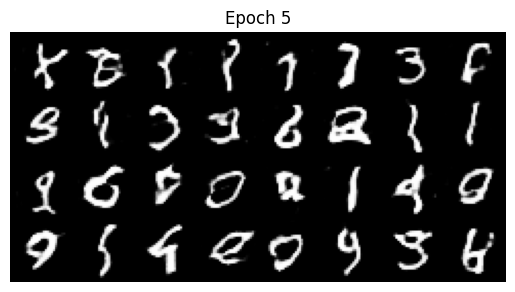

Epoch [6/20] Batch 400 Loss D: -0.1048, Loss G: 0.0206
Epoch [6/20] Batch 800 Loss D: -0.0848, Loss G: 0.1057


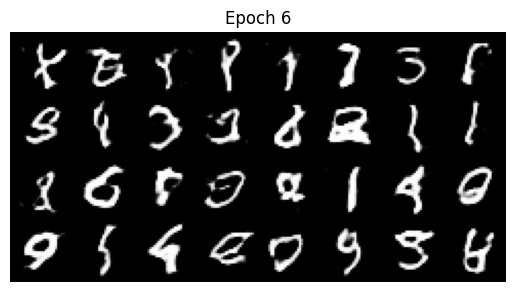

Epoch [7/20] Batch 400 Loss D: -0.0773, Loss G: 0.1067
Epoch [7/20] Batch 800 Loss D: -0.0672, Loss G: 0.0977


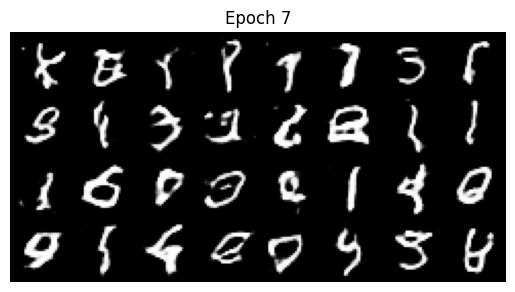

Epoch [8/20] Batch 400 Loss D: -0.1065, Loss G: 0.0599
Epoch [8/20] Batch 800 Loss D: -0.0657, Loss G: 0.0964


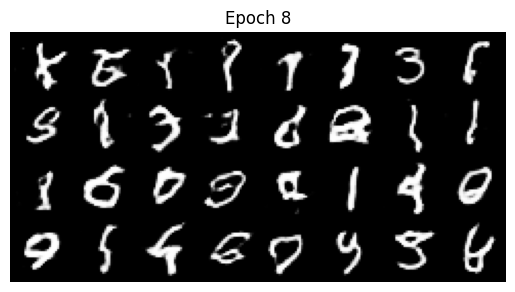

Epoch [9/20] Batch 400 Loss D: -0.0797, Loss G: 0.0971
Epoch [9/20] Batch 800 Loss D: -0.0787, Loss G: 0.1128


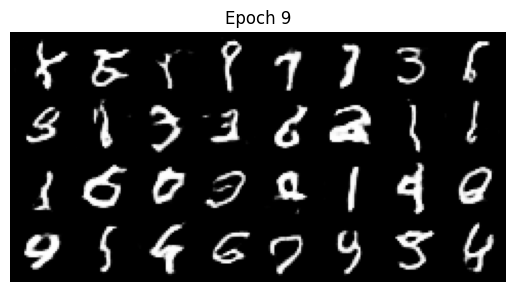

Epoch [10/20] Batch 400 Loss D: -0.0849, Loss G: 0.0637
Epoch [10/20] Batch 800 Loss D: -0.0646, Loss G: 0.0985


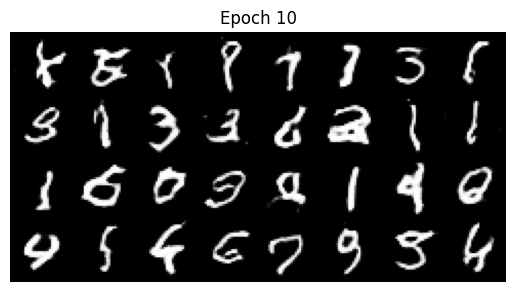

Epoch [11/20] Batch 400 Loss D: -0.0802, Loss G: 0.1157
Epoch [11/20] Batch 800 Loss D: -0.0737, Loss G: 0.1082


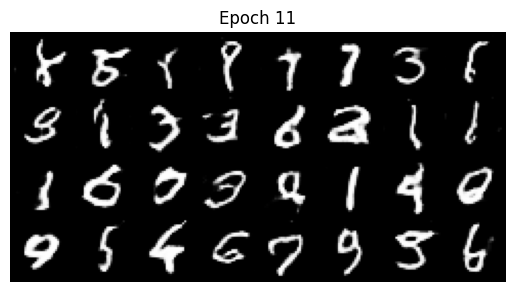

Epoch [12/20] Batch 400 Loss D: -0.0832, Loss G: 0.0595
Epoch [12/20] Batch 800 Loss D: -0.0631, Loss G: 0.0049


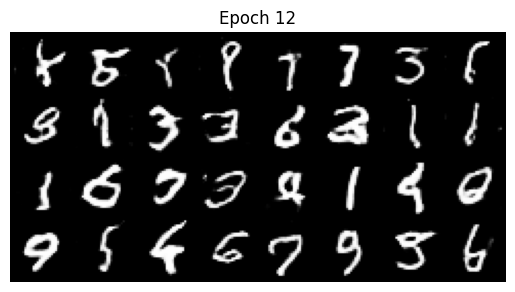

Epoch [13/20] Batch 400 Loss D: -0.0695, Loss G: 0.0972
Epoch [13/20] Batch 800 Loss D: -0.0768, Loss G: 0.0594


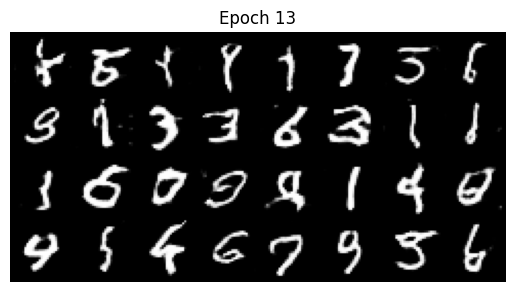

Epoch [14/20] Batch 400 Loss D: -0.0649, Loss G: 0.1023
Epoch [14/20] Batch 800 Loss D: -0.0839, Loss G: -0.0101


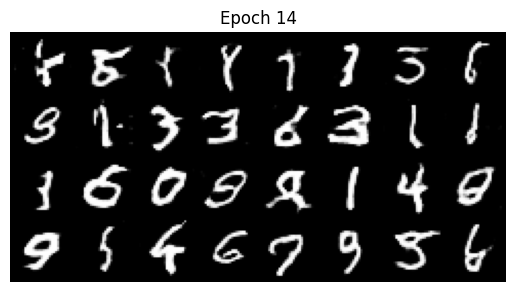

Epoch [15/20] Batch 400 Loss D: -0.0816, Loss G: -0.0110
Epoch [15/20] Batch 800 Loss D: -0.0592, Loss G: 0.0845


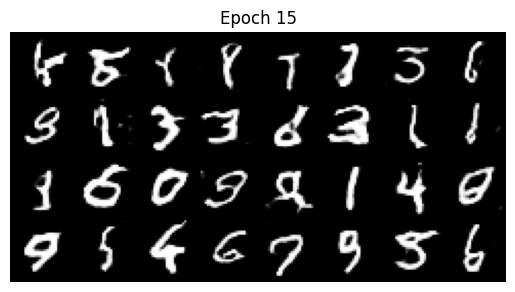

Epoch [16/20] Batch 400 Loss D: -0.0834, Loss G: -0.0061
Epoch [16/20] Batch 800 Loss D: -0.0695, Loss G: 0.0583


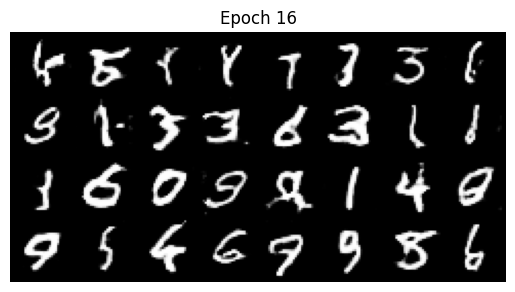

Epoch [17/20] Batch 400 Loss D: -0.0556, Loss G: -0.0263
Epoch [17/20] Batch 800 Loss D: -0.0627, Loss G: -0.0186


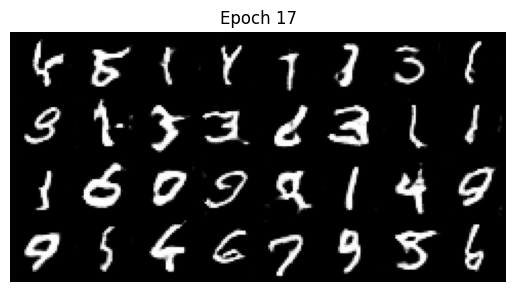

Epoch [18/20] Batch 400 Loss D: -0.0599, Loss G: -0.0168
Epoch [18/20] Batch 800 Loss D: -0.0666, Loss G: 0.0207


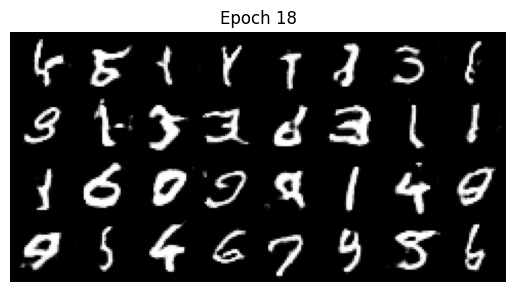

Epoch [19/20] Batch 400 Loss D: -0.0805, Loss G: 0.0086
Epoch [19/20] Batch 800 Loss D: -0.0644, Loss G: -0.0158


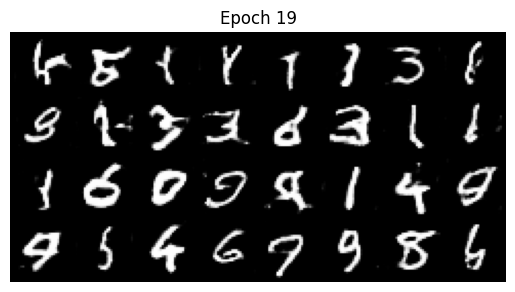

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# --- Hyperparameters ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LR = 5e-5
BATCH_SIZE = 64
IMAGE_SIZE = 28
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 20
FEATURES_D = 64
FEATURES_G = 64
N_CRITIC = 5        # Critic iterations per generator step
WEIGHT_CLIP = 0.01  # WGAN Lipschitz constraint

# --- Data ---
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]), # Normalize to [-1, 1]
])

dataset = torchvision.datasets.MNIST(root="dataset/", train=True, transform=transform, download=True)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# --- Models ---
class Critic(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Critic, self).__init__()
        self.critic = nn.Sequential(
            # Input: N x 1 x 28 x 28
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # 14x14
            nn.Conv2d(features_d, features_d * 2, 4, 2, 1),
            nn.BatchNorm2d(features_d * 2),
            nn.LeakyReLU(0.2),
            # 7x7
            nn.Conv2d(features_d * 2, features_d * 4, 4, 2, 1),
            nn.BatchNorm2d(features_d * 4),
            nn.LeakyReLU(0.2),
            # 3x3 -> Output scalar score (No Sigmoid for WGAN)
            nn.Conv2d(features_d * 4, 1, kernel_size=3, stride=1, padding=0),
        )

    def forward(self, x):
        return self.critic(x)

class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x Z_DIM x 1 x 1
            nn.ConvTranspose2d(channels_noise, features_g * 16, 4, 1, 0),
            nn.BatchNorm2d(features_g * 16),
            nn.ReLU(),
            # 4x4
            nn.ConvTranspose2d(features_g * 16, features_g * 8, 4, 2, 1),
            nn.BatchNorm2d(features_g * 8),
            nn.ReLU(),
            # 8x8
            nn.ConvTranspose2d(features_g * 8, features_g * 4, 4, 2, 1),
            nn.BatchNorm2d(features_g * 4),
            nn.ReLU(),
            # 16x16 -> Output 28x28 (Using specific padding/stride for MNIST)
            nn.ConvTranspose2d(features_g * 4, channels_img, 4, 2, 3),
            nn.Tanh() 
        )

    def forward(self, x):
        return self.net(x)

# --- Init & Optimizers ---
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_G).to(DEVICE)
critic = Critic(CHANNELS_IMG, FEATURES_D).to(DEVICE)

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

gen.apply(initialize_weights)
critic.apply(initialize_weights)

# RMSprop is recommended for standard WGAN (Adam induces instability with clipping)
opt_gen = optim.RMSprop(gen.parameters(), lr=LR)
opt_critic = optim.RMSprop(critic.parameters(), lr=LR)

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(DEVICE)

# --- Training Loop ---
print("Starting Standard WGAN Training on MNIST...")

for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(DEVICE)
        
        # 1. Train Critic
        for _ in range(N_CRITIC):
            noise = torch.randn(real.shape[0], Z_DIM, 1, 1).to(DEVICE)
            fake = gen(noise)
            
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            
            # WGAN Loss: Maximize E[D(real)] - E[D(fake)]
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
            
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

            # Weight Clipping (Lipschitz constraint enforcement)
            for p in critic.parameters():
                p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)

        # 2. Train Generator
        # Generator maximizes E[D(fake)]
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        if batch_idx % 400 == 0 and batch_idx > 0:
            print(f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx} Loss D: {loss_critic:.4f}, Loss G: {loss_gen:.4f}")

    # Visualization
    with torch.no_grad():
        fake_viz = gen(fixed_noise)
        grid = torchvision.utils.make_grid(fake_viz[:32], normalize=True)
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.title(f"Epoch {epoch}")
        plt.axis("off")
        plt.show()